# Comparación *drivings* óptimos con el AR máximo obtenido para cada grafo

En este notebook primero se definen los drivings óptimos que se han obtenido, se simula la evolución para cada grafo y después se comaparan estos resultados con los mejores resultados que cada grafo ha conseguido a nivel individual.

In [ ]:
from src.ahs_utils import show_register, show_drive_and_local_detuning, show_final_avg_density
from braket.ahs.atom_arrangement import AtomArrangement
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from braket.ahs.local_detuning import LocalDetuning

from src.aitor_utils import Graph_gen, C_from_gr, get_blockade_configurations2, Gurobi_solver, Gurobi_to_gr
from src.drivings_aitor import Drivings2
from src.aitor_utils import plot_sp_ar

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from tqdm import tqdm

simulator = LocalSimulator("braket_ahs")

# Definición de los *drivings*

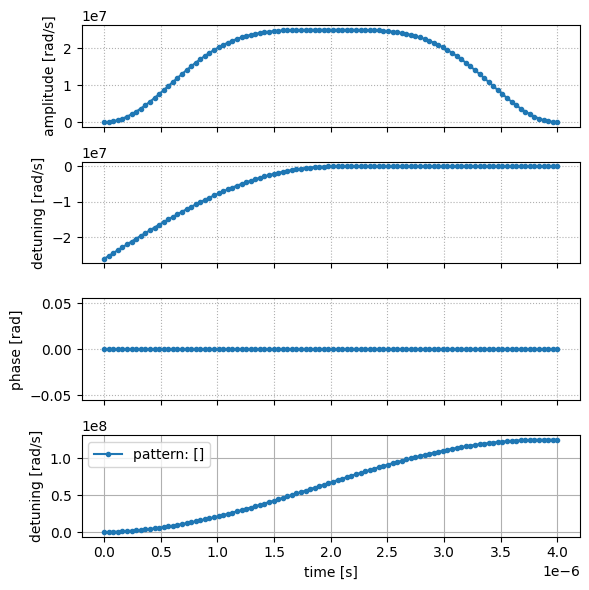

In [3]:
# Definición de parámetros de los drivings
time_max = 4
# Valores conseguidos en gridsearch_3
Delta_max =  0.413793 * 125 * 1e6 #RAD/S
Delta_local_max = 1* 125 * 1e6 #BEST 
Omega_max = 1 * 25 *1e6  #RAD/S
# Valores conseguidos por BO
Delta_0 = [0.97429029, 0.10169132, 0.98861248, 0.44340385]
Delta_0 = [1.0, 0.0035, 0.9849, 0.4757]

og_weights = []
drive, local_detuning_drive, delta_local_array, time = Drivings2(time_max, Omega_max, Delta_max, Delta_local_max, og_weights, Delta_0)

show_drive_and_local_detuning(drive , local_detuning_drive)

# Simulación de los 1000 grafos

In [ ]:
# Cargar base de datos de los grafos
df = pd.read_csv('../data/res_1000_simulado.csv')

In [ ]:
simul = pd.DataFrame(columns=['n_nodos', 'atoms_w', 'atoms_l', 'seed', 'p_0', 'p_1', 'e_gap', 'e_0', 'e_1', 'succ', 'ar'])

# Definimos los parámetros de la simulación
scale = 5e-6
C = 862690 * 2 * np.pi # um^6 * rad / us
blockade_radius=7.1e-6
shots = 20000
steps = 1000

# Calculamos la adiabaticidad para cada grafo
for i in tqdm(range(len(df))):
    # Generamos el grafo
    n_nodos = df.loc[i, 'n_nodos']
    atoms_w = df.loc[i, 'atoms_w']
    atoms_l = df.loc[i, 'atoms_l']
    seed = df.loc[i, 'seed']
    np.random.seed(seed)
    graph, atoms = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

    pattern = [float(i) for i in nx.get_node_attributes(graph, 'weight').values()]
    positions = np.array(list(nx.get_node_attributes(graph, 'pos').values()))

    # Defino los drivings
    local_detuning_drive = LocalDetuning.from_lists(times=time,
                                                    values=delta_local_array,
                                                    pattern=pattern)

    # Defino el hamiltoniano
    program = AnalogHamiltonianSimulation(hamiltonian=drive + local_detuning_drive,
                                        register=atoms)

    # Ejecutamos la simulacion
    device = LocalSimulator("braket_ahs")
    result = device.run(program, steps=steps, shots=shots, blockade_radius=blockade_radius).result()
    counters = result.get_counts()
    gr_list = list(counters.keys())
    Counts = list(counters.values())
        
    # Calculamos la energía de cada bitstring obtenido en la simulacion
    counters = pd.DataFrame({'bitstring': gr_list, 'Counts': Counts})
    counters['e_H'] = [C_from_gr(gr, pattern, graph.edges()) for gr in counters['bitstring']]
    counters = counters.sort_values(by='Counts', ascending=False)

    # Calculo la solución de gurobi y su SP
    optimal_value, opt_solutions = Gurobi_solver(graph)
    gur_solution = Gurobi_to_gr(opt_solutions, len(graph.nodes()))

    if gur_solution in list(counters['bitstring']):
        succ = float(list(counters[counters['bitstring'] == gur_solution]['Counts'])[0] / shots)
    else:
        succ = 0

    # Calculo el AR
    ar = float(sum(counters['e_H'] * counters['Counts']) / shots / optimal_value)

    # Calcular el espectro del grafo
    conf = get_blockade_configurations2(positions, 7.2e-6)
    espectro = pd.DataFrame(conf, columns=['bitstring'])
    espectro['energia'] = espectro['bitstring'].apply(lambda x: C_from_gr(x, pattern, graph.nodes()))
    espectro = espectro.sort_values('energia', ascending=True)

    e_gap = espectro['energia'].values[1] - espectro['energia'].values[0]
    e_min = espectro['energia'].values[0]


    # Probabilidad del estado menos energético
    p_0 = list(counters['Counts'])[0]/shots
    # Probabilidad del segundo menos energético
    if len(counters) == 1:
        p_1 = 0
    else:
        p_1 = list(counters['Counts'])[1]/shots

    new_data = {'n_nodos': n_nodos, 'atoms_w': atoms_w, 'atoms_l': atoms_l, 'seed': seed, 'p_0': p_0, 'p_1': p_1, 'e_gap': e_gap, 'e_0': e_min, 'e_1': espectro['energia'].values[1], 'succ': succ, 'ar': ar}
    simul = pd.concat([simul, pd.DataFrame([new_data])], ignore_index=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2025-11-24


C:\Users\aitoo\AppData\Local\Temp\ipykernel_14540\1754477304.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  simul = pd.concat([simul, pd.DataFrame([new_data])], ignore_index=True)
100%|██████████| 1000/1000 [1:00:22<00:00,  3.62s/it]


In [4]:
# simul.to_csv(f'simul_drivings_opt_1000_seeds.csv', index=False)
simul = pd.read_csv(f'simul_drivings_opt_1000_seeds.csv')

**Mostramos los resultados**

In [5]:
print('AR promedio:', simul.ar.mean())

AR promedio: 0.9964033729446269


[-0.2  0.   0.2  0.4  0.6  0.8  1. ]
[-0.2  0.   0.2  0.4  0.6  0.8  1. ]


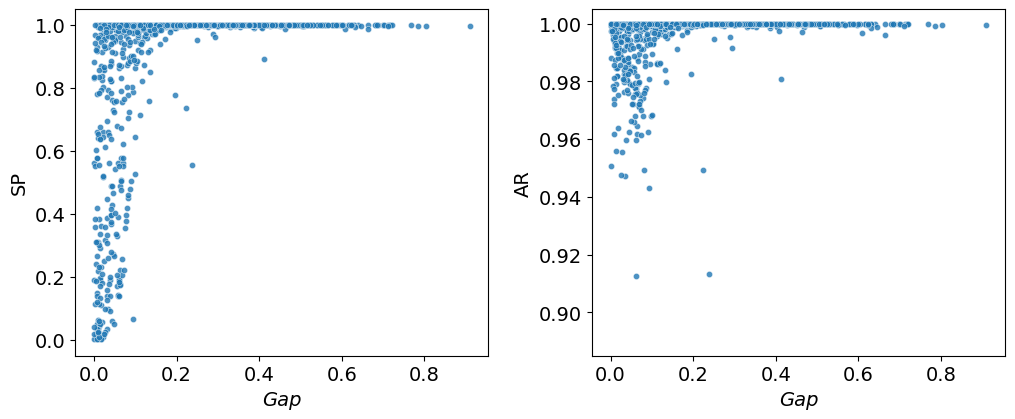

In [5]:
plot_sp_ar(simul)

# Comparación de resultados

**Cargar los resultados de la optimización por grafo**

In [6]:
# Cargar resultados
df_opt = pd.read_csv('../Estudio opt por grafo/opt_por_seed.csv')
# Añadimos la columna de e_gap a la base de datos
df_opt = df_opt.merge(simul[['seed', 'e_gap']], on='seed', how='left')

In [7]:
df_opt.AR_max.mean()

np.float64(0.9981214518707301)

**Comparar scatterplot**

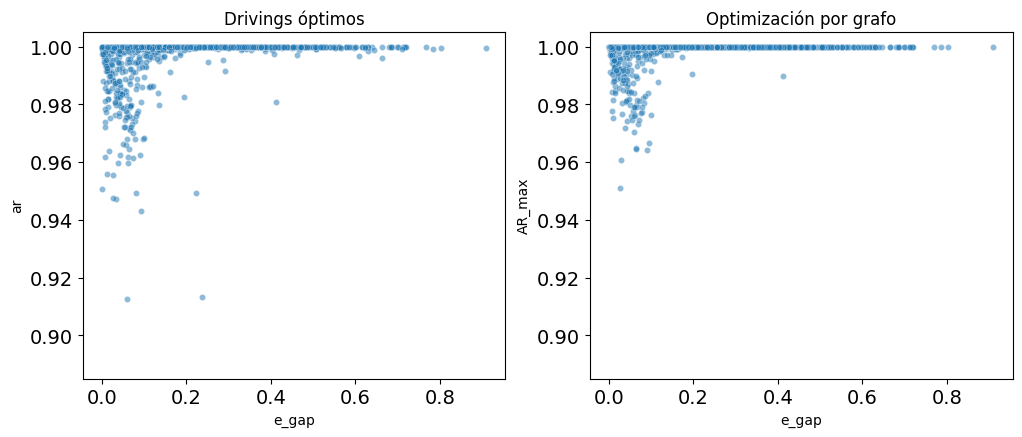

In [13]:
import matplotlib.pyplot as plt

# Crear una figura con 1 fila y 2 columnas de subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))  # 1 fila, 2 columnas

# Primer gráfico (izquierda)
sns.scatterplot(x='e_gap', y='ar', data=simul, alpha=0.5, ax=axs[0], s=20)
axs[0].set_ylim(0.885, 1.005)
axs[0].set_title('Drivings óptimos')
axs[0].tick_params(axis='both', labelsize=14)



# Segundo gráfico (derecha)
sns.scatterplot(x='e_gap', y='AR_max', data=df_opt, alpha=0.5, ax=axs[1], s=20)
axs[1].set_ylim(0.885, 1.005)
axs[1].set_title('Optimización por grafo')
axs[1].tick_params(axis='both', labelsize=14)

# Ajustar diseño para que no se sobrepongan

# plt.tight_layout()
plt.show()


**Calcular la MAE entre ambos**

In [10]:
# Hacemos un DataFrame con las semillas y los AR:
df_ar = simul[['seed', 'e_gap','ar']].copy()
df_ar = df_ar.merge(df_opt[['seed', 'AR_max']], on='seed', how='left')
df_ar = df_ar.rename(columns={'ar': 'AR_drivings'})

In [27]:
# Calculamos la diferencia entre los ARs
df_ar['AR_diff'] = df_ar['AR_drivings'] - df_ar['AR_max']
print('MAE:', abs(df_ar['AR_diff']).mean())

MAE: 0.001718286980971314


<Axes: xlabel='AR_diff', ylabel='Count'>

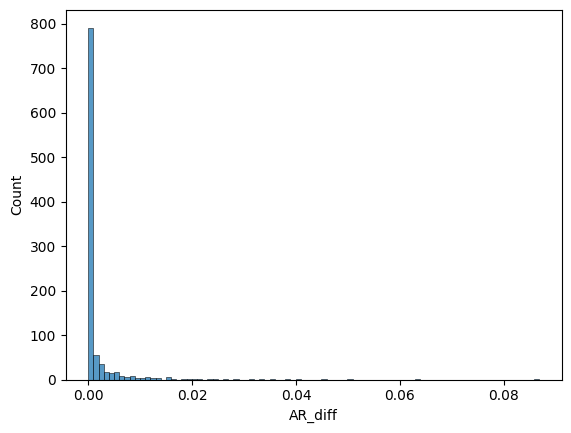

In [25]:
sns.histplot(x=df_ar['AR_diff'].abs(), binwidth=0.001)


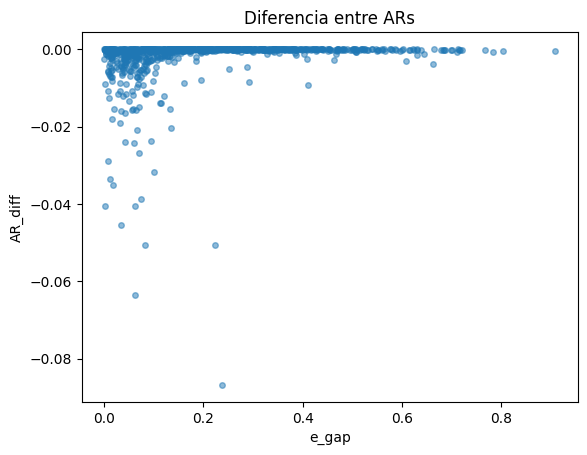

In [12]:
# Mostramos el error frente al gap
plt.plot(df_ar['e_gap'], df_ar['AR_diff'], 'o', markersize=4, alpha=0.5)
plt.xlabel('e_gap')
plt.ylabel('AR_diff')
plt.title('Diferencia entre ARs')
plt.show()